# Kaggle challenge : H1B Visa Petitions 
 COLIBERT Alice, FOËNET Julien, KEMADJOU Elodie & RIGUCCINI Marine

In [180]:
# Imports

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn import preprocessing


%matplotlib inline

# Machine Learning

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Datas are available at : https://www.kaggle.com/nsharan/h-1b-visa

In [181]:
# Import the data h1b_kaggle from csv into a DataFrame

visa_df = pd.read_csv("/Users/julienfoenet/Desktop/DATA_SCIENCE/Kaggle/h1b_kaggle.csv")

# Preview the data

visa_df.info()
visa_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002458 entries, 0 to 3002457
Data columns (total 11 columns):
Unnamed: 0            int64
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  float64
WORKSITE              object
lon                   float64
lat                   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 252.0+ MB


,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [182]:
# We drop the column 'Unnamed: 0' which is useless for analysis and prediction
# We also drop columns 'lon' and 'lat' indeed we already have a variable 'WORKSITE'

visa_df.drop("Unnamed: 0", axis=1, inplace=True)
visa_df.drop("lat", axis=1, inplace=True)
visa_df.drop("lon", axis=1, inplace=True)

# We delete all missing datas

visa_df = visa_df.dropna()


In [183]:
# CASE_STATUS

visa_df.CASE_STATUS.value_counts()


CERTIFIED                                             2600241
CERTIFIED-WITHDRAWN                                    201479
DENIED                                                  93761
WITHDRAWN                                               89110
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64

In [184]:
# We keep only the categories 'CERTIFIED', 'DENIED', 'WITHDRAWN' and 'CERTIFIED-WITHDRAWN' since the others are irrelevant
# We group together 'CERTIFIED-WITHDRAWN' and 'WITHDRAWN' since they both mean not certified in the end

listCaseStatus = ['CERTIFIED','CERTIFIED-WITHDRAWN','WITHDRAWN','DENIED']
visa_df = visa_df[visa_df["CASE_STATUS"].isin(listCaseStatus)]
visa_df['CASE_STATUS'].loc[visa_df['CASE_STATUS'] == "CERTIFIED-WITHDRAWN"] = "WITHDRAWN"

# The aim of this project is to analyse the influence of other parameters on weather a visa has been certified or not
# We now replace the variable 'CASE_STATUS' with the variable 'CERTIFIED_RATE' use for analysis and prediction
# which is the ratio between certified and not certified: 1 for CERTIFIED and 0 for (WITHDRAWN + DENIED)
# We create also a second variable 'CERTIFIED_DENIED_RATE' which is the ratio only between certified and denied:
# It will help for the analysis of certain variables like YEAR or PREVAILING_WAGE

visa_df['CERTIFIED_RATE'] = 1
visa_df['CERTIFIED_RATE'].loc[visa_df['CASE_STATUS'].isin(["WITHDRAWN", "DENIED"])] = 0

visa_df['CERTIFIED_DENIED_RATE'] = 1
visa_df['CERTIFIED_DENIED_RATE'].loc[visa_df['CASE_STATUS'].isin(["DENIED"])] = 0

visa_df = visa_df.drop(['CASE_STATUS'], axis=1)


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [185]:
# EMPLOYER_NAME spelling correction

# Some names contains points, comas or shorts
# We remove it in order to regroup the different names that correspond to the same company
    
visa_df['EMPLOYER_NAME'] = visa_df['EMPLOYER_NAME'].str.upper()

listEmployer = visa_df['EMPLOYER_NAME'].tolist()
listEmployerNew = []
for i in listEmployer:
        listEmployerNew.append(i.replace('.','').replace(',','').replace('INC','').replace('LLC','').replace('LLP','').replace('  ',' ').strip())
    
visa_df['EMPLOYER_NAME'] = listEmployerNew


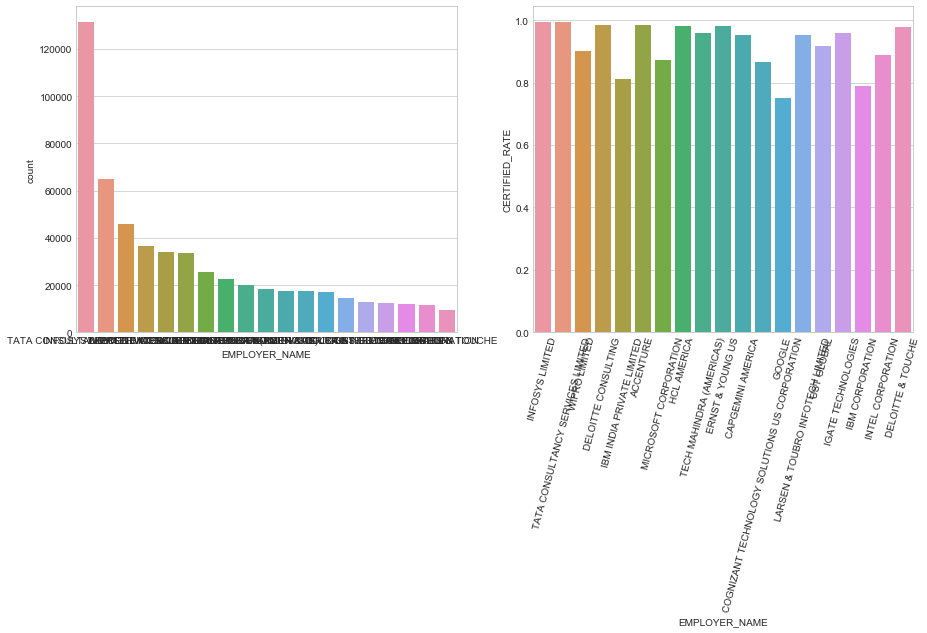

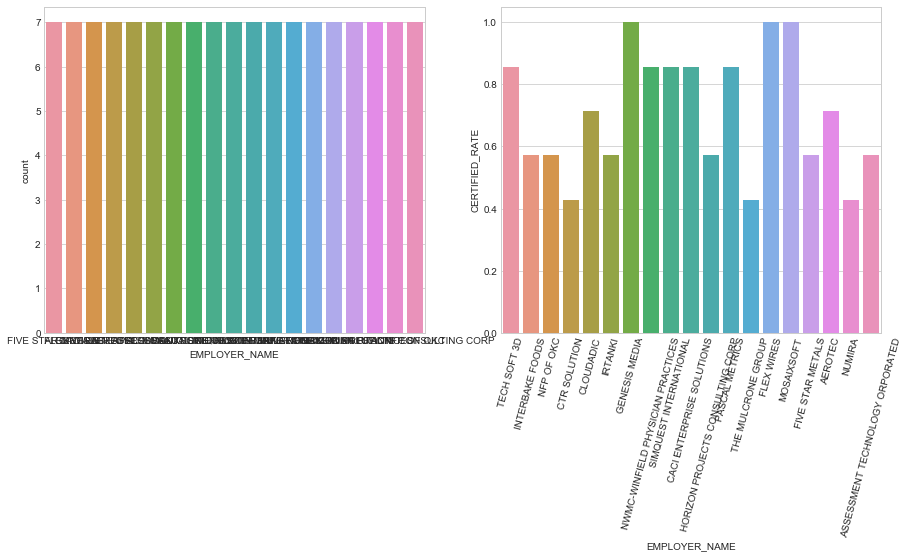

In [186]:
# EMPLOYER_NAME

# First, we remove the employers with less than 5 visa demands 
# since they are irrelevant/not significative and may corrupt the analysis

tuple1 = [(x,y) for x, y in visa_df['EMPLOYER_NAME'].value_counts().items()]
listEmployerName2 = []
j=0
while j<len(tuple1):
    if tuple1[j][1] > 5:
        listEmployerName2.append(tuple1[j][0])
    j+=1
visa_df = visa_df[visa_df['EMPLOYER_NAME'].isin(listEmployerName2)]

# Then we check if there is a difference in term of certified rate 
# between the biggest employers (with lots of visa demands) and the small ones

listEmployerName = visa_df.EMPLOYER_NAME.value_counts().index.tolist()
listEmployerNameNew1 = listEmployerName[0:19]
listEmployerNameNew2 = listEmployerName[30000:30019]
visa_df_20_1 = visa_df[visa_df["EMPLOYER_NAME"].isin(listEmployerNameNew1)]
visa_df_20_2 = visa_df[visa_df["EMPLOYER_NAME"].isin(listEmployerNameNew2)]


employer_perc1 = visa_df_20_1[["EMPLOYER_NAME", "CERTIFIED_RATE"]].groupby(['EMPLOYER_NAME'], as_index=False).mean()
employer_perc2 = visa_df_20_2[["EMPLOYER_NAME", "CERTIFIED_RATE"]].groupby(['EMPLOYER_NAME'], as_index=False).mean()



fig, (axis1,axis2) = plt.subplots(1,2, figsize=(15,6))
plt.xticks(rotation=75)
sns.countplot(x='EMPLOYER_NAME', data=visa_df_20_1, order=listEmployerNameNew1, ax=axis1)
sns.barplot(x='EMPLOYER_NAME', y='CERTIFIED_RATE', data=employer_perc1, order=listEmployerNameNew1, ax=axis2)
fig, (axis3,axis4) = plt.subplots(1,2, figsize=(15,6))
plt.xticks(rotation=75)
sns.countplot(x='EMPLOYER_NAME', data=visa_df_20_2, ax=axis3)
sns.barplot(x='EMPLOYER_NAME', y='CERTIFIED_RATE', data=employer_perc2, order=listEmployerNameNew2, ax=axis4)


# The biggest employers grant more visa than the small ones:
# Let's see if this is real for all the data and not just for the exemple above
# To do that we compute the average of certified rate comparate to the size
# of the employer (total number of visa demands)


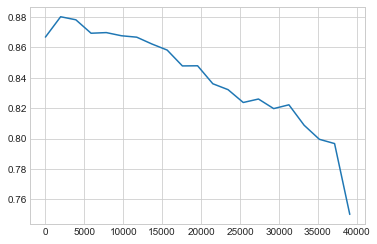

In [187]:
# EMPLOYER_NAME (2nd Part)

i = 0
nE = visa_df.EMPLOYER_NAME.value_counts().size
listAvgEmp = []
kE = int(nE/20)

while i < nE :
    listEmployerName = visa_df.EMPLOYER_NAME.value_counts().index.tolist()
    listEmployerNameNew = listEmployerName[i:i+kE]
    visa_df_20_4 = visa_df[visa_df["EMPLOYER_NAME"].isin(listEmployerNameNew)]
    employer_perc = visa_df_20_4[["EMPLOYER_NAME", "CERTIFIED_RATE"]].groupby(['EMPLOYER_NAME'], as_index = False).mean()
    avg1 = employer_perc.mean()
    listAvgEmp.append(avg1)
    i+=kE
    
ll_Emp = []
j=0
while j<len(listEmployerName):
    ll_Emp.append(j)
    j+=kE
    
plt.plot(ll_Emp,listAvgEmp)

# the curb is decreasing, EMPLOYER_NAME has an influence on the CERTIFIED_RATE:
# the more visa demands the employer has, the higher the probabilty of 
# those visas is to be certified


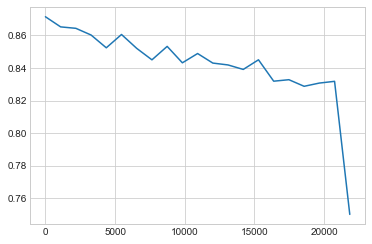

In [188]:
# JOB_TITLE 

# First, we remove all the job title with less than 5 visa demands
# since they are irrelevant and skew the analysis

tuple3 = [(x,y) for x, y in visa_df['JOB_TITLE'].value_counts().items()]
listJobName2 = []
j=0
while j<len(tuple3):
    if tuple3[j][1] > 5:
        listJobName2.append(tuple3[j][0])
    j+=1
visa_df = visa_df[visa_df['JOB_TITLE'].isin(listJobName2)]

visa_df.count
visa_df['JOB_TITLE'].value_counts()

# We compute the average of certified rate for every size of job title
# in decreasing order from the highest (most visa demands) to the smallest

i = 0
nJ = visa_df.JOB_TITLE.value_counts().size
listAvgJob = []
kJ = int(nJ/20)

while i < nJ :
    listJobName = visa_df.JOB_TITLE.value_counts().index.tolist()
    listJobNameNew = listJobName[i:i+kJ]
    visa_df_20_4 = visa_df[visa_df["JOB_TITLE"].isin(listJobNameNew)]
    job_perc = visa_df_20_4[["JOB_TITLE", "CERTIFIED_RATE"]].groupby(['JOB_TITLE'], as_index = False).mean()
    avg1 = job_perc.mean()
    listAvgJob.append(avg1)
    i+=kJ
    
ll_Job = []
j=0
while j<len(listJobName):
    ll_Job.append(j)
    j+=kJ
    
plt.plot(ll_Job,listAvgJob)



In [ ]:
# SOC_NAME 

# Variable SOC_NAME is qualitative and contains too many different instances.
# We decid to group into 25 categories the different job types of the variable SOC_NAME 

# Dictionary of types of soc_name
replace_soc_dict = {
    'SALES REPRESENTATIVES, WHOLESALE AND':'FINANCE & SALES',
    'SOFTWARE DEVELOPERS, APPLICATIONS': 'SOFTWARE DEVELOPERS',
    'SOFTWARE DEVELOPERS, SYSTEMS SOFTWARE': 'SOFTWARE DEVELOPERS',
    'COMPUTER SOFTWARE ENGINEERS, SYSTEMS SOFTWARE':'SOFTWARE DEVELOPERS',
    'SOFTWARE QUALITY ASSURANCE ENGINEERS AND TESTERS':'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEMS ENGINEERS/ARCHITECTS':'SOFTWARE DEVELOPERS',
    'COMPUTER SOFTWARE ENGINEERS, APPLICATIONS':'SOFTWARE DEVELOPERS',
    'COMPUTER PROGRAMMERS': 'SOFTWARE DEVELOPERS',
    'COMPUTER PROGRAMMER':'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEMS ENGINEERS':'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEMS ENGINEERS OR ARCHITECTS': 'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEMS ENGINEERS / ARCHITECTS': 'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEM ENGINEERS/ARCHITECTS':'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEMS ENGINEERS, ARCHITECTS' : 'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEMS ENGINEERS/ ARCHITECTS': 'SOFTWARE DEVELOPERS',
    'COMPUTER SOFTWARE ENGINEERS, APPLICATIONS NON R&D':'SOFTWARE DEVELOPERS',
    'SOFTWARE ENGINEER':'SOFTWARE DEVELOPERS',
    'COMPUTER SPECIALISTS':'COMPUTER SYSTEMS',
    'COMPUTER NETWORK ARCHITECTS':'COMPUTER SYSTEMS',
    'COMPUTER SUPPORT SPECIALISTS':'COMPUTER SYSTEMS',
    'COMPUTER SYSTEMS ENGINEERS/ARQUITECTS':'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEMS ENGINEERS/ARCHITECT':'SOFTWARE DEVELOPERS',
    'COMPUTER SYSTEMS ENGINEER':'SOFTWARE DEVELOPERS',
    'SENIOR SOFTWARE ENGINEER':'SOFTWARE DEVELOPERS',
    'COMPUTER OCCUPATIONS':'COMPUTER SYSTEMS',
    'COMPUTER USER SUPPORT SPECIALISTS':'COMPUTER SYSTEMS',
    'COMPUTER NETWORK SUPPORT SPECIALISTS':'COMPUTER SYSTEMS',
    'COMPUTER AND INFORMATION SYSTEMS MANAGERS':'COMPUTER SYSTEMS',
    'DATABASE ADMINISTRATORS':'COMPUTER SYSTEMS',
    'DATABASE ADMINISTRATOR':'COMPUTER SYSTEMS',
    'ELECTRONICS ENGINEERS' : 'ENGINEERS',
    'MECHANICAL ENGINEERS' : 'ENGINEERS',
    'INDUSTRIAL ENGINEERS' : 'ENGINEERS',
    'BIOMEDICAL ENGINEERS' : 'ENGINEERS',
    'ENGINEERING TECHNICIANS' : 'TECHNICIANS',
    'BIOCHEMISTS': 'SCIENTISTS',
    'PHYSICISTS': 'SCIENTISTS',
    'BIOCHEMISTS': 'SCIENTISTS',
    'BIOCHEMISTS AND BIOPHYSICISTS': 'SCIENTISTS',
    'MICROBIOLOGISTS': 'SCIENTISTS',
    'MATHEMATICIANS':'SCIENTISTS',
    'ASTRONOMERS':'SCIENTISTS',
    'CHEMISTS':'SCIENTISTS',
    'STATISTICIANS':'SCIENTISTS',
    'ZOOLOGISTS AND WILDLIFE BIOLOGISTS':'SCIENTISTS',
    'DENTISTS, GENERAL':'HEALTHCARE PROFESSIONALS',
    'OPTOMETRISTS':'HEALTHCARE PROFESSIONALS',
    'PSYCHOLOGISTS':'HEALTHCARE PROFESSIONALS',
    'CLINICAL, COUNSELING, AND SCHOOL PSYCHOLOGISTS':'HEALTHCARE PROFESSIONALS',
    'DIETITIANS AND NUTRITIONISTS':'HEALTHCARE PROFESSIONALS',
    'OBSTETRICIANS AND GYNECOLOGISTS':'HEALTHCARE PROFESSIONALS',
    'EPIDEMIOLOGISTS':'HEALTHCARE PROFESSIONALS',
    'DENTISTS, ALL OTHER SPECIALISTS':'HEALTHCARE PROFESSIONALS',
    'HEALTHCARE PRACTITIONERS AND TECHNICAL WORKERS,':'HEALTHCARE PROFESSIONALS',
    'PSYCHIATRISTS':'HEALTHCARE PROFESSIONALS',
    'REGISTERED NURSES':'HEALTHCARE PROFESSIONALS',
    'PEDIATRICIANS, GENERAL':'HEALTHCARE PROFESSIONALS',
    'HEALTH DIAGNOSING AND TREATING PRACTITIONERS, ALL':'HEALTHCARE PROFESSIONALS',
    'OCCUPATIONAL THERAPISTS':'HEALTHCARE PROFESSIONALS',
    'DENTISTS, GENERAL':'HEALTHCARE PROFESSIONALS',
    'MEDICAL AND CLINICAL LABORATORY TECHNOLOGISTS':'HEALTHCARE PROFESSIONALS',
    'HEALTHCARE PRACTITIONERS AND TECHNICAL WORKERS, AL':'HEALTHCARE PROFESSIONALS',
    'PHARMACISTS':'HEALTHCARE PROFESSIONALS',
    'SPEECH-LANGUAGE PATHOLOGISTS':'HEALTHCARE PROFESSIONALS',
    'INTERNISTS, GENERAL':'HEALTHCARE PROFESSIONALS',
    'PHYSICIANS AND SURGEONS':'HEALTHCARE PROFESSIONALS',
    'PHYSICAL THERAPISTS':'HEALTHCARE PROFESSIONALS',
    'CHIROPRACTORS':'HEALTHCARE PROFESSIONALS',
    'SURGEONS':'HEALTHCARE PROFESSIONALS',
    'ANESTHESIOLOGISTS':'HEALTHCARE PROFESSIONALS',
    'CLERGY':'RELIGIOUS ACTIVITIES',
    'JUDICIAL LAW CLERKS':'LAW AND LEGAL ACTIVITIES',
    'LAWYERS':'LAW AND LEGAL ACTIVITIES',
    'PARALEGALS AND LEGAL ASSISTANTS': 'LAW AND LEGAL ACTIVITIES',
    'LEGAL SUPPORT WORKERS':'LAW AND LEGAL ACTIVITIES',
    'WRITERS AND AUTHORS':'ART ACTIVITIES',
    'ART ACTIVITIES':'ART ACTIVITIES',
    'ART DIRECTORS':'ART ACTIVITIES',
    'PRODUCERS AND DIRECTORS':'ART ACTIVITIES',
    'MULTI-MEDIA ARTISTS AND ANIMATORS':'ART ACTIVITIES',
    'CURATORS':'ART ACTIVITIES',
    'MUSIC DIRECTORS AND COMPOSERS':'ART ACTIVITIES',
    'EDITORS':'ART ACTIVITIES',
    'FILM AND VIDEO EDITORS':'ART ACTIVITIES',
    'REPORTERS AND CORRESPONDENTS':'MEDIA ACTIVITIES',
    'MEDIA AND COMMUNICATION WORKERS':'MEDIA ACTIVITIES',
    'COMPENSATION, BENEFITS, AND JOB ANALYSIS SPECIALIS':'HUMAN RESOURCES',
    'COACHES AND SCOUTS':'EDUCATION AND SPORTS',
    'ATHLETIC TRAINERS':'EDUCATION AND SPORTS',
    'ACCOUNTANTS':'FINANCE & SALES',
    'SALES REPRESENTATIVES':'FINANCE & SALES',
    'SALES ENGINEERS':'FINANCE & SALES',
    'FINANCIAL EXAMINERS':'FINANCE & SALES',
    'LANDSCAPE ARCHITECTS':'ARCHITECTS',
    'FINANCIAL ANALYSTS':'ANALYSTS',
    'MANAGEMENT ANALYSTS':'ANALYSTS',
    'MARKET RESEARCH ANALYSTS':'ANALYSTS',
    'OPERATIONS RESEARCH ANALYSTS':'ANALYSTS',
    'ARCHITECTURAL AND ENGINEERING MANAGERS':'MANAGERS',
    'MARKETING MANAGER':'MANAGERS',
    'MARKETING MANAGERS':'MANAGERS',
    'ENGINEERING MANAGER':'MANAGERS',
    'ENGINEERING MANAGERS':'MANAGERS',
    'AIRLINE PILOTS, COPILOTS, AND FLIGHT ENGINEERS':'AIRLINE PILOTS',
    'GENERAL AND OPERATIONS MANAGERS':'MANAGERS',
    'MARKET RESEARCH ANALYSTS AND MARKETING':'FINANCE & SALES',
    'MARKET RESEARCH ANALYSTS AND MARKETING SPECIALISTS':'FINANCE & SALES',
    'MEDICAL AND HEALTH SERVICES MANAGERS':'MANAGERS',
    'FINANCIAL SPECIALISTS':'FINANCE & SALES',
    'COST ESTIMATORS':'FINANCE & SALES',
    'EDUCATION ADMINISTRATORS':'EDUCATION AND SPORTS',
    'EDUCATION ADMINISTRATORS, ELEMENTARY AND SECONDARY':'EDUCATION AND SPORTS',
    'EDUCATION ADMINISTRATORS, POSTSECONDARY':'EDUCATION AND SPORTS',
    'MUSIC DIRECTORS':'ART ACTIVITIES',
    'DIRECTORS, RELIGIOUS ACTIVITIES AND EDUCATION':'MANAGERS',
    'EMERGENCY MANAGEMENT DIRECTORS':'MANAGERS',
    'EDUCATIONAL, GUIDANCE, SCHOOL, AND VOCATIONAL':'EDUCATION AND SPORTS',
    'EDUCATION ADMINISTRATORS, PRESCHOOL AND CHILDCARE':'ADMINISTRATORS',
    'LIBRARIANS':'EDUCATION AND SPORTS',
    'RECREATION WORKERS':'EDUCATION AND SPORTS',
    'CHILD, FAMILY, AND SCHOOL SOCIAL WORKERS':'EDUCATION AND SPORTS',
    'BOOKKEEPING, ACCOUNTING, AND AUDITING CLERKS':'LAW AND LEGAL ACTIVITIES',
    'MENTAL HEALTH COUNSELORS':'HEALTHCARE PROFESSIONALS',
    'AUDITORS':'LAW AND LEGAL ACTIVITIES',
    'WEB DEVELOPERS':'SOFTWARE DEVELOPERS',
    'WEB ADMINISTRATORS':'COMPUTER SYSTEMS',
    'SALES REPRESENTATIVES':'FINANCE & SALES',
    'HEALTH EDUCATORS':'EDUCATION AND SPORTS',
    'SALES MANAGERS':'FINANCE & SALES',
    'FINANCIAL MANAGERS':'FINANCE & SALES',
    'AGENTS AND BUSINESS MANAGERS OF ARTISTS':'ART ACTIVITIES',
    'ACTUARIES':'LAW AND LEGAL ACTIVITIES',
    'CHIEF EXECUTIVES':'MANAGERS',
    'FASHION DESIGNERS':'DESIGNERS',
    'MULTIMEDIA ARTISTS AND ANIMATORS':'ART ACTIVITIES',
    'INTERIOR DESIGNERS':'DESIGNERS',
    'PERSONAL FINANCIAL ADVISORS':'FINANCE & SALES',
    'COMPLIANCE OFFICERS':'LAW AND LEGAL ACTIVITIES',
    'SURVEY RESEARCHERS':'SCIENTISTS',
    'OCCUPATIONAL HEALTH AND SAFETY SPECIALISTS':'HEALTHCARE PROFESSIONALS',
    'SECURITIES, COMMODITIES, AND FINANCIAL SERVICES':'FINANCE & SALES',
    'WHOLESALE AND RETAIL BUYERS':'FINANCE & SALES',
    'TRAINING AND DEVELOPMENT SPECIALISTS':'EDUCATION AND SPORTS',
    'FAMILY AND GENERAL PRACTITIONERS':'HEALTHCARE PROFESSIONALS',
    'PUBLIC RELATIONS SPECIALISTS':'MEDIA ACTIVITIES',
    'COMMERCIAL AND INDUSTRIAL DESIGNERS':'DESIGNERS',
    'SECURITIES, COMMODITIES, AND FINANCIAL SERVICES SA':'FINANCE & SALES',
    'INSTRUCTIONAL COORDINATORS':'EDUCATION AND SPORTS',
    'SALES REPRESENTATIVES, WHOLESALE AND MANUFACTURING':'FINANCE & SALES',
    'PURCHASING AGENTS':'FINANCE & SALES',
    'GRAPHIC DESIGNERS':'DESIGNERS',
    'BUSINESS OPERATIONS SPECIALISTS':'FINANCE & SALES',
    'REHABILITATION COUNSELORS':'EDUCATION AND SPORTS',
    'ARCHITECTURAL AND CIVIL DRAFTERS':'ARCHITECTS',
    'URBAN AND REGIONAL PLANNERS':'ARCHITECTS',
    'MEETING, CONVENTION, AND EVENT PLANNERS':'MEDIA ACTIVITIES',
    'TECHNICAL WRITERS':'ENGINEERS',
    'SOCIAL SCIENCE RESEARCH ASSISTANTS':'SCIENTISTS',
}


In [190]:
# SOC_NAME classification in types


# Functions for cleaning names:

def endcut(astring, trailing): # Remove what's after the word
    thelen = len(trailing)
    if astring[-thelen:] == trailing:
        return astring[:-thelen]
    return astring

def removeafter(astring, text): # Delete everything after this text
    paridx = astring.find(text)
    if paridx >= 0:
        return astring[0:paridx]
    return astring


def patchsoctitle(soctitle): 
    # uppercase, trim and replace multiple spaces in middle
    soctitle = " ".join(soctitle.upper().split())
    # remove anything after
    soctitle = removeafter(soctitle, " (")
    soctitle = removeafter(soctitle, ", EXCEPT")
    soctitle = removeafter(soctitle, ", INCLUDIN")
    # remove suffixes
    soctitle = endcut(soctitle,"*")
    soctitle = endcut(soctitle,", ALL OTHER")
    soctitle = endcut(soctitle,", NON R&D")
    soctitle = endcut(soctitle,", NON R & D")
    soctitle = endcut(soctitle,", R&D")
    soctitle = endcut(soctitle,", NON-R&D")
    soctitle = endcut(soctitle," NON R & D")
    soctitle = endcut(soctitle,", SENIOR")
    soctitle = endcut(soctitle,", R&AMP;D")

    # Replace with values from replace_dict
    if soctitle in replace_soc_dict:
        soctitle = replace_soc_dict[soctitle]

    if "COMPUTER SYSTEM" in soctitle:
        soctitle = "COMPUTER SYSTEMS"

    if "TEACHER" in soctitle:
        soctitle = "TEACHERS AND INSTRUCTORS"

    if "INSTRUCTOR" in soctitle:
        soctitle = "TEACHERS AND INSTRUCTORS"

    if "HUMAN RESOURCE" in soctitle:
        soctitle = "HUMAN RESOURCES"

    if "TECHNICIAN" in soctitle:
        soctitle = "TECHNICIANS"

    if "SCIENTIST" in soctitle:
        soctitle = "SCIENTISTS"

    if "ENGINEER" in soctitle:
        soctitle = "ENGINEERS"

    if "ANALYST" in soctitle:
        soctitle = "ANALYSTS"

    if "EDUCATION" in soctitle and soctitle != "EDUCATION AND SPORTS":
        soctitle = "EDUCATION AND SPORTS"

    if "MANAGER" in soctitle:
        soctitle = "MANAGERS"

    # unclassified yet
    return soctitle


soc_idx = {
    "RELIGIOUS ACTIVITIES":1,
    "CHEFS AND HEAD COOKS":2,
    "MODELS":3,
    "INTERPRETERS AND TRANSLATORS":4,
    "VETERINARIANS":5,
    "ECONOMISTS":6,
    "LOGISTICIANS":7,
    "HUMAN RESOURCES":8,
    "MEDIA ACTIVITIES":9,
    "ARCHITECTS":10,
    "ART ACTIVITIES":11,
    "TECHNICIANS":12,
    "NA":0,
    "EDUCATION AND SPORTS":13,
    "LAW AND LEGAL ACTIVITIES":4,
    "DESIGNERS":15,
    "ACCOUNTANTS AND AUDITORS":16,
    "MANAGERS":17,
    "TEACHERS AND INSTRUCTORS":18,
    "FINANCE & SALES":19,
    "HEALTHCARE PROFESSIONALS":20,
    "SCIENTISTS":21,
    "ANALYSTS":22,
    "ENGINEERS":23,
    "COMPUTER SYSTEMS":24,
    "SOFTWARE DEVELOPERS":25,
}



# Get the soc_idx for each soc_type
def soc_idx_from_txt(soc):
    if soc in soc_idx:
        return soc_idx[soc]
    return 0

   
# We create a new column in our DataFrame and put in the SOC_TYPE corresponding 
listSocType = []
listPar = []
list_idx = ["RELIGIOUS ACTIVITIES","CHEFS AND HEAD COOKS","MODELS","INTERPRETERS AND TRANSLATORS","VETERINARIANS","ECONOMISTS","LOGISTICIANS","HUMAN RESOURCES","MEDIA ACTIVITIES","ARCHITECTS","ART ACTIVITIES","TECHNICIANS","NA","EDUCATION AND SPORTS","LAW AND LEGAL ACTIVITIES","DESIGNERS","ACCOUNTANTS AND AUDITORS","MANAGERS","TEACHERS AND INSTRUCTORS","FINANCE & SALES","HEALTHCARE PROFESSIONALS","SCIENTISTS","ANALYSTS","ENGINEERS","COMPUTER SYSTEMS","SOFTWARE DEVELOPERS"]

for soc in visa_df['SOC_NAME']:
    listSocType.append(soc_idx_from_txt(patchsoctitle(soc)))
    listPar.append(list_idx[soc_idx_from_txt(patchsoctitle(soc))])
    

    
visa_df['SOC_NAME'] = listPar
visa_df['SOC_NAME'] = visa_df['SOC_NAME'].loc[visa_df['SOC_NAME'] != 0]
visa_df['SOC_NAME'].value_counts()


SOFTWARE DEVELOPERS             872442
COMPUTER SYSTEMS                759187
ENGINEERS                       134859
ANALYSTS                        120156
SCIENTISTS                      108254
HEALTHCARE PROFESSIONALS         91815
TEACHERS AND INSTRUCTORS         62959
FINANCE & SALES                  40036
ACCOUNTANTS AND AUDITORS         32670
MANAGERS                         27190
DESIGNERS                        15118
VETERINARIANS                    11113
NA                               10794
RELIGIOUS ACTIVITIES              9615
EDUCATION AND SPORTS              5808
ART ACTIVITIES                    5144
TECHNICIANS                       4682
MEDIA ACTIVITIES                  4515
HUMAN RESOURCES                   3381
ARCHITECTS                        3273
LOGISTICIANS                      3141
ECONOMISTS                        1179
INTERPRETERS AND TRANSLATORS      1173
MODELS                             234
CHEFS AND HEAD COOKS                70
Name: SOC_NAME, dtype: in

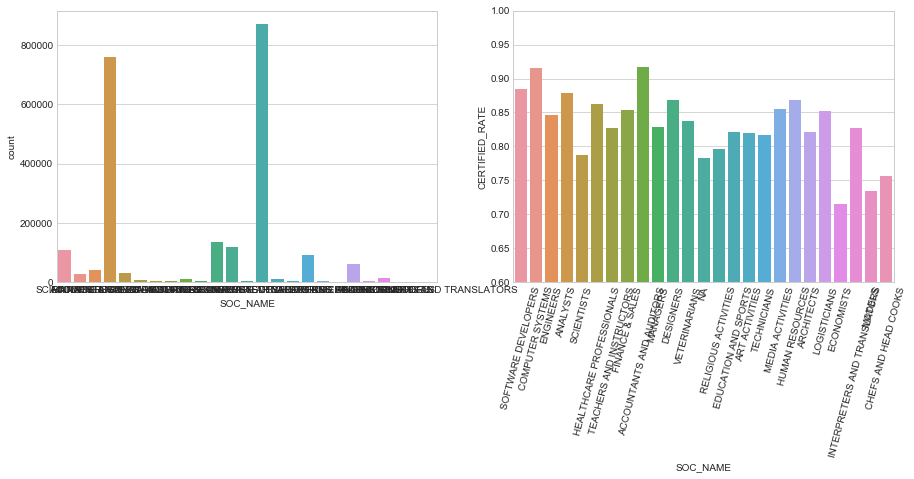

In [191]:
#  Variable SOC_NAME 

# Graphics 
listSocName = visa_df.SOC_NAME.value_counts().index.tolist()

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='SOC_NAME', data=visa_df, ax=axis1)

soc_perc = visa_df[['SOC_NAME', "CERTIFIED_RATE"]].groupby(['SOC_NAME'], as_index=False).mean()
plt.ylim(0.6,1)
plt.xticks(rotation=75)
sns.barplot(x="SOC_NAME", y='CERTIFIED_RATE', data=soc_perc,order=listSocName, ax=axis2)




In [192]:
# WORKSITE

# 'WORKSITE' is a variable with inside (City, State) 
# We split 'WORKSITE' into two different variables: 'CITY' and 'STATE'

city = []
state = []
for x in visa_df["WORKSITE"]:
    city.append(x.split(",")[0])
    state.append(x.split(", ")[1])
visa_df['CITY'] = city
visa_df['STATE'] = state

# We then drop the variable 'WORKSITE'

visa_df = visa_df.drop(["WORKSITE"],axis=1)


In [193]:
# CITY and STATE spelling correction

listCity = visa_df.CITY.value_counts().index.tolist() 
listState = visa_df.STATE.value_counts().index.tolist()

# Our DataFrame contains the name of 50 US states, plus the Federal District name and Puerto Rico
# Some strings contains spelling mistakes
# To keep only the correct ones, we creat a new DataFrame cities_df
# which regroup all more than 15000 inhabitants US cities, correctly spelt

# We download 'World cities' datas from Kaggle

cities_df = pd.read_csv("/Users/julienfoenet/Desktop/DATA_SCIENCE/Kaggle/world-cities.csv")
cities_df.info()
cities_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23018 entries, 0 to 23017
Data columns (total 4 columns):
name          23018 non-null object
country       23018 non-null object
subcountry    22992 non-null object
geonameid     23018 non-null int64
dtypes: int64(1), object(3)
memory usage: 719.4+ KB


,name,country,subcountry,geonameid
0,les Escaldes,Andorra,Escaldes-Engordany,3040051
1,Andorra la Vella,Andorra,Andorra la Vella,3041563
2,Umm al Qaywayn,United Arab Emirates,Umm al Qaywayn,290594
3,Ras al-Khaimah,United Arab Emirates,Raʼs al Khaymah,291074
4,Khawr Fakkān,United Arab Emirates,Ash Shāriqah,291696


Database World Cities (imported from Kaggle) available at :
https://www.kaggle.com/okfn/world-cities

In [194]:
# Database cities_df

cities_df['name'] = cities_df['name'].str.upper()
cities_df['subcountry'] = cities_df['subcountry'].str.upper()

# We drop useless variables 'geonameid'
cities_df.drop("geonameid", axis=1, inplace=True)

# We only keep United States' and Puerto Rico's cities
cities_df = cities_df[cities_df["country"].isin(['United States','Puerto Rico'])]

# We adopt the same writing term for the Federal District and cut the short
cities_df['name'].loc[cities_df['name'] == "Washington, D.C."] = "Washington"
cities_df['subcountry'].loc[cities_df['subcountry'] == "Washington, D.C."] = "District of Columbia"

# We do not care about Puerto Rico's subcountries so we replace it only by 'Puerto Rico'
cities_df['subcountry'].loc[cities_df['country'] == "Puerto Rico"] = "Puerto Rico"

# Finally, we only keep the variables 'name' and 'subcountry'
cities_df.drop("country", axis=1, inplace=True)


# We could now keep only the well spelt US cities and states in our DataFrame

visa_df = visa_df[visa_df['CITY'].isin(cities_df['name'])]
visa_df = visa_df[visa_df['STATE'].isin(cities_df['subcountry'])]

# Thanks to this [...] voir codes.copies.py

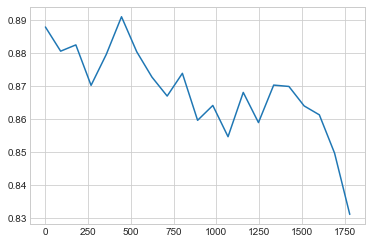

In [195]:
# CITY 
# we remove all the cities with less than 6 visas

tuple4 = [(x,y) for x, y in visa_df['CITY'].value_counts().items()]
listCityName2 = []
j=0
while j<len(tuple4):
    if tuple4[j][1] > 6:
        listCityName2.append(tuple4[j][0])
    j+=1
visa_df = visa_df[visa_df['CITY'].isin(listCityName2)]

# We compute the average of certified rate for all size of city

i = 0
nC = visa_df.CITY.value_counts().size
listAvgCity = []
kC = int(nC/20)

while i < nC :
    listCityName = visa_df.CITY.value_counts().index.tolist()
    listCityNameNew = listCityName[i:i+kC]
    visa_df_20_4 = visa_df[visa_df["CITY"].isin(listCityNameNew)]
    city_perc = visa_df_20_4[["CITY", "CERTIFIED_RATE"]].groupby(['CITY'], as_index = False).mean()
    avg1 = city_perc.mean()
    listAvgCity.append(avg1)
    i+=kC
    
ll_City = []
j=0
while j<len(listCityName):
    ll_City.append(j)
    j+=kC
    
plt.plot(ll_City,listAvgCity)



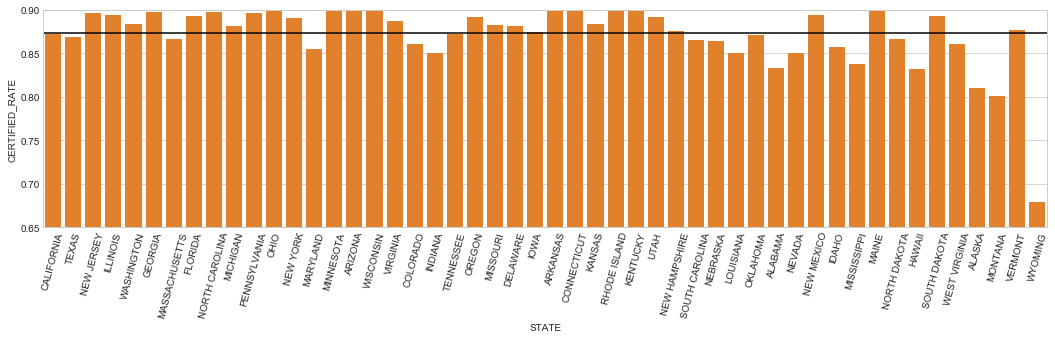

In [196]:
# STATE 

visa_df = visa_df[visa_df['STATE'] != 'NA']

i = 0
nS = visa_df.STATE.value_counts().size
listAvgState = []

while i < nS :
    listStateName = visa_df.STATE.value_counts().index.tolist()
    listStateNameNew = listStateName[i:i+1]
    visa_df_20_4 = visa_df[visa_df["STATE"].isin(listStateNameNew)]
    state_perc = visa_df_20_4[["STATE", "CERTIFIED_RATE"]].groupby(['STATE'], as_index = False).mean()
    avg1 = state_perc.mean()
    listAvgState.append(avg1)
    i+=1


fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_STATE = visa_df[["STATE", "CERTIFIED_RATE"]].groupby(['STATE'],as_index=False).mean()
y_av = average_STATE.mean()
plt.ylim(0.65,0.9)
plt.xticks(rotation=75)
sns.barplot(x='STATE', y='CERTIFIED_RATE', data=average_STATE, color='C1',order=listStateName)
plt.hlines(y_av,-1,100,color='k',)


In [205]:
# FULL_TIME_POSITION and PREVAILING_WAGE

# We transform the wage into int for easier analysis
visa_df['PREVAILING_WAGE'] = visa_df['PREVAILING_WAGE'].astype(int)

# We compute the average of wage for full time and part time position
wage_perc = visa_df[["PREVAILING_WAGE", "FULL_TIME_POSITION"]].groupby(['FULL_TIME_POSITION'], as_index = False).mean()    
print(wage_perc)

# The wages for full time position are slightly more than two times higher
# than the ones corresponding to part time position
# To analyse the wages we need to double the wages corresponding to part time position

visa_df['PREVAILING_WAGE'][visa_df['FULL_TIME_POSITION'] == 'N'] = visa_df['PREVAILING_WAGE'][visa_df['FULL_TIME_POSITION'] == 'N'] * 2.4

# We print the average of certified visa for full time and part time
# It's almost the same, we conclude that this variable has no influence on it: we can remove it

print(visa_df[["FULL_TIME_POSITION", "CERTIFIED_RATE"]].groupby(['FULL_TIME_POSITION'],as_index=False).mean())
visa_df.drop("FULL_TIME_POSITION", axis=1, inplace=True)


KeyError: "['FULL_TIME_POSITION'] not in index"

              0
0  77678.341694
1  81620.019446
              0
0  28574.781996
1  75162.083793


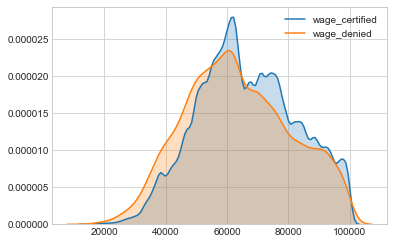

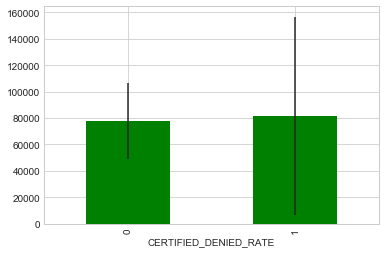

In [198]:
# PREVAILING_WAGE 

# Some wages go above billion, some are equal to zero, thus we need to delete them
# In order to remove these non relevant wages, 
# we put limits for the wages (minimum: 7.5$ per hour, maximum: 150000$ per year)

min_wage = 7.25*40*4*12
max_wage = 1500000
visa_df = visa_df[visa_df['PREVAILING_WAGE'] > min_wage]
visa_df = visa_df[visa_df['PREVAILING_WAGE'] < max_wage]

# We seprate two cases: the wages of certified visas and the wages of non certified visas
# We compute the mean and std for those two 'PREVAILING_WAGE'

wage_certified = visa_df["PREVAILING_WAGE"][visa_df["CERTIFIED_DENIED_RATE"] == 1 ]
wage_denied = visa_df["PREVAILING_WAGE"][visa_df["CERTIFIED_DENIED_RATE"] == 0 ]
avg_wage = DataFrame([wage_certified.mean(), wage_denied.mean()])
std_wage = DataFrame([wage_certified.std(), wage_denied.std()])
print(avg_wage)
print(std_wage)

# Plot of frequency of wage for both cases: certified and denied
# For the high and medium wages the rate of certified is higher
# For the low wages the rate of denied is higher

sns.kdeplot(wage_certified,shade=True, label="wage_certified", clip=(0,100000))
sns.kdeplot(wage_denied,shade=True, label="wage_denied",clip=(0,100000))

# Plot of mean and standard deviation
# Although the mean of wages are the same for certified and denied visas,
# The standard deviation is much higher for denied than for certified visas
# with very high or very low wages are more often denied than those with medium wages

avg_wage.index.names = std_wage.index.names = ["CERTIFIED_DENIED_RATE"]
avg_wage.plot(yerr = std_wage, kind='bar', color='g', legend=False)


0.991448514423
0.988591749427
0.984990806557
0.981925245882
0.974486455958
0.957875107322


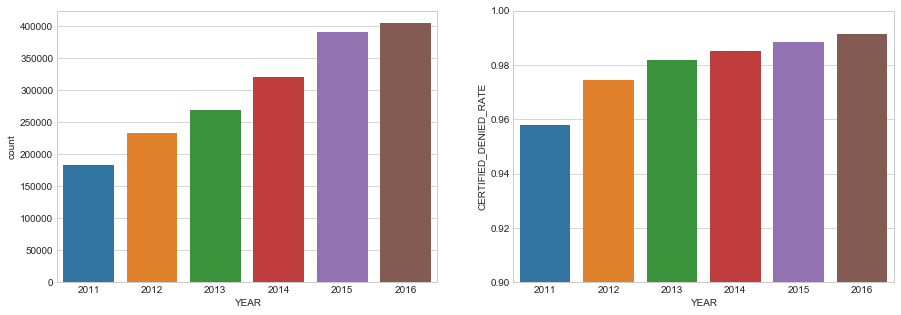

In [199]:
# YEAR

# We change YEAR (float) into int and then into string since YEAR is a class and is not numerical

visa_df["YEAR"] = visa_df["YEAR"].astype(int)
visa_df["YEAR"] = visa_df["YEAR"].astype(str)

# We compute the average of certified rate for each year

i=0
nY = visa_df.YEAR.value_counts().size
listAvgYear = []
listAvgYear2 = []

while i < nY:
    listYearName = visa_df.YEAR.value_counts().index.tolist()
    visa_df_20_4 = visa_df[visa_df["YEAR"] == listYearName[i]]
    year_perc = visa_df_20_4[["YEAR", "CERTIFIED_DENIED_RATE"]].groupby(['YEAR'], as_index = False).mean()
    avg1 = year_perc.mean()
    listAvgYear.append(avg1)
    listAvgYear2.append(listAvgYear[i][1])
    i+=1
    
for elt in listAvgYear2:
    print(elt)
    
# Plot of the average of certified/denied rate per year
# The number of visa demands is really increasing each year since 2011
# There is a small increase in the rate of certified along with the year:
# in 2016 your visa has more chance to be certified than the previous year,
# and this since 2011, but the difference is still small (from 0.99 to 0.95)

fig, (axis1,axis2) = plt.subplots(1,2, figsize=(15,5))
listYear = visa_df.YEAR.value_counts().index.tolist()
listYear.sort()
sns.countplot(x='YEAR', data=visa_df,ax=axis1)
year_perc = visa_df[["YEAR", "CERTIFIED_DENIED_RATE"]].groupby(['YEAR'], as_index=False).mean()
plt.ylim(0.9,1)
sns.barplot(x='YEAR', y='CERTIFIED_DENIED_RATE', data=year_perc, order=listYear)


In [200]:
# Prediction 
# Step 1 : variables transformation

# We change every categorical variable into an int in order to perform predictive methods

listYEAR = visa_df.YEAR.value_counts().index.tolist()
visa_listYEAR = visa_df.YEAR.tolist()
le = preprocessing.LabelEncoder()
le.fit(listYEAR)
le.classes_
listYearTransformed = le.transform(visa_df.YEAR)
visa_df["YEAR"] = listYearTransformed

listEMPLOYER = visa_df.EMPLOYER_NAME.value_counts().index.tolist()
visa_listEMPLOYER = visa_df.EMPLOYER_NAME.tolist()
le = preprocessing.LabelEncoder()
le.fit(listEMPLOYER)
le.classes_
listEmployerTransformed = le.transform(visa_df.EMPLOYER_NAME)
visa_df["EMPLOYER_NAME"] = listEmployerTransformed

listSOC = visa_df.SOC_NAME.value_counts().index.tolist()
visa_listSOC = visa_df.SOC_NAME.tolist()
le = preprocessing.LabelEncoder()
le.fit(listSOC)
le.classes_
listSocTransformed = le.transform(visa_df.SOC_NAME)
visa_df["SOC_NAME"] = listSocTransformed

listJOB = visa_df.JOB_TITLE.value_counts().index.tolist()
visa_listJOB = visa_df.JOB_TITLE.tolist()
le = preprocessing.LabelEncoder()
le.fit(listJOB)
le.classes_
listJobTransformed = le.transform(visa_df.JOB_TITLE)
visa_df["JOB_TITLE"] = listJobTransformed

listCITY = visa_df.CITY.value_counts().index.tolist()
visa_listCITY = visa_df.CITY.tolist()
le = preprocessing.LabelEncoder()
le.fit(listCITY)
le.classes_
listCityTransformed = le.transform(visa_df.CITY)
visa_df["CITY"] = listCityTransformed

listSTATE= visa_df.STATE.value_counts().index.tolist()
visa_listSTATE = visa_df.STATE.tolist()
le = preprocessing.LabelEncoder()
le.fit(listSTATE)
le.classes_
listStateTransformed = le.transform(visa_df.STATE)
visa_df["STATE"] = listStateTransformed


In [201]:
# Prediction 
# Step 2 : creation of test and training samples

# We split the dataFrame in two samples picked at random :
# the training sample (9/10 of all the rows) 
# and the test sample (1/10 of all the rows) 

n=len(visa_df.index)
V=10
visa_df_test = visa_df.sample(n=n//V)
visa_df_test.YEAR.value_counts()
visa_df_test.index
visa_df_train = visa_df.drop(visa_df_test.index)

X_train = visa_df_train.drop(["CERTIFIED_RATE"], axis=1)
Y_train = visa_df_train["CERTIFIED_RATE"]
X_test = visa_df_test.drop(["CERTIFIED_RATE"], axis=1).copy()
Y_test = visa_df_test["CERTIFIED_RATE"]


In [202]:
# Prediction 
# Step 3 : Predictive methods

# Random Forest

clf = RandomForestClassifier(verbose=3)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

clf.score(X_train, Y_train)


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished


0.963965452302738

In [203]:
# Knn

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)


0.91174260473757895

In [204]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)

gaussian.score(X_train, Y_train)


0.87813312736057536